In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import gc
from IPython.core.display import display, HTML, display_pretty
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import lightgbm as lgb
from imblearn.datasets import make_imbalance
os.chdir('/home/sambeet/data/dsg/')

In [2]:
trade = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
trade['BuySell'] = trade['BuySell'].astype('category')
trade['TradeStatus'] = trade['TradeStatus'].astype('category')
trade['CustomerInterest'] = trade['CustomerInterest'].astype('bool')
trade['year'] = trade.TradeDateKey.dt.year
trade['month'] = trade.TradeDateKey.dt.month
trade['weekofyear'] = trade.TradeDateKey.dt.weekofyear

In [3]:
trade.head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,NotionalEUR,Price,TradeStatus,CustomerInterest,year,month,weekofyear
0,2016-12-07,2789,8478,Sell,653168.0,0.0,Unknown,True,2016,12,49
1,2017-03-29,2574,14562,Buy,1656487.0,0.0,Unknown,True,2017,3,13
2,2017-04-18,2574,4747,Buy,939673.0,0.0,Unknown,True,2017,4,16
3,2017-03-10,2574,9885,Sell,708082.0,0.0,Unknown,True,2017,3,10
4,2016-11-16,2574,8885,Buy,1147709.0,0.0,Unknown,True,2016,11,46


In [4]:
#trade = trade[trade.CustomerInterest == 1].groupby(['CustomerIdx','IsinIdx','BuySell','year','month','weekofyear'])['CustomerInterest'].sum().reset_index()
trade = trade.groupby(['CustomerIdx','IsinIdx','BuySell','year','month','weekofyear'])['CustomerInterest'].sum().reset_index()

In [5]:
trade['CustomerInterest'] = 1

trade['BuySell'] = trade['BuySell'].astype('category')
encoder = LabelEncoder()
encoder.fit(trade['BuySell'].astype(str))    
trade['BuySell'] = encoder.transform(trade['BuySell'].astype(str))

encoder.transform(['Buy','Sell'])

In [6]:
trade.shape

(6280924, 7)

In [7]:
#marketdata = pd.read_csv('Market.csv',parse_dates=['DateKey'])
#macromarketdata = pd.read_csv('MarketData_Macro.csv',parse_dates=['DateKey'])
customer = pd.read_csv('Customer.csv')
categorical_columns = ['Sector','Subsector','Region','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
categorical_columns = ['Seniority','Currency','ActivityGroup','Region','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')
customer = customer.rename({'Region':'CustomerRegion'},axis=1)
trade = trade.merge(customer,on=['CustomerIdx'],how='left')
bond = bond.rename({'Region':'BondRegion'},axis=1)
trade = trade.merge(bond,on=['IsinIdx'],how='left')
#trade['days_issued'] = (trade['TradeDateKey'] - trade['IssueDateKey']).dt.days
#trade['days_maturity'] = (trade['ActualMaturityDateKey'] - trade['TradeDateKey']).dt.days
test_submit = pd.read_csv('Challenge_20180423.csv',parse_dates=['DateKey'])
test_submit = test_submit.rename({'DateKey':'TradeDateKey'},axis=1)
test_submit['BuySell'] = test_submit['BuySell'].astype('category')
test_submit['TradeDateKey'] = '20180423'
test_submit['TradeDateKey'] = pd.to_datetime(test_submit.TradeDateKey)
test_submit['year'] = test_submit.TradeDateKey.dt.year
test_submit['month'] = test_submit.TradeDateKey.dt.month
test_submit['weekofyear'] = test_submit.TradeDateKey.dt.weekofyear
test_submit = test_submit.merge(customer,on=['CustomerIdx'],how='left')
test_submit = test_submit.merge(bond,on=['IsinIdx'],how='left')
#test_submit['days_issued'] = (test_submit['TradeDateKey'] - test_submit['IssueDateKey']).dt.days
#test_submit['days_maturity'] = (test_submit['ActualMaturityDateKey'] - test_submit['TradeDateKey']).dt.days
del customer, bond
gc.collect()
categorical_to_be_transformed = ['BuySell','Sector','Subsector','CustomerRegion', 'Country','Seniority','Currency',
                                 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 
                                 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue','CouponType']
for feature in categorical_to_be_transformed:
    print 'Transforming {}...'.format(feature)
    encoder = LabelEncoder()
    encoder.fit(trade[feature].append(test_submit[feature]).astype(str))    
    trade[feature] = encoder.transform(trade[feature].astype(str))
    test_submit[feature] = encoder.transform(test_submit[feature].astype(str))

Transforming BuySell...
Transforming Sector...
Transforming Subsector...
Transforming CustomerRegion...
Transforming Country...
Transforming Seniority...
Transforming Currency...
Transforming ActivityGroup...
Transforming BondRegion...
Transforming Activity...
Transforming RiskCaptain...
Transforming Owner...
Transforming CompositeRating...
Transforming IndustrySector...
Transforming IndustrySubgroup...
Transforming MarketIssue...
Transforming CouponType...


trade['wom'] = trade['TradeDateKey'].apply(lambda d: (d.day-1) // 7 + 1)
test['wom'] = test['TradeDateKey'].apply(lambda d: (d.day-1) // 7 + 1)

In [8]:
categorical = categorical_to_be_transformed + ['year','CustomerIdx','IsinIdx']#,'quarter','weekofyear']
categorical.remove('BuySell')
predictors = list(trade.columns)
#predictors.remove('TradeDateKey')
#predictors.remove('IsinIdx')
#predictors.remove('Price')
predictors.remove('CustomerInterest')
predictors.remove('BuySell')
predictors.remove('ActualMaturityDateKey')
predictors.remove('IssueDateKey')
#predictors.remove('TradeStatus')
#predictors.remove('NotionalEUR')
#predictors.remove('BondPrice')
#predictors.remove('Yield')
#predictors.remove('ZSpread')
#predictors.remove('day')
#predictors.remove('weekday')
predictors.remove('TickerIdx')
predictors.remove('weekofyear')
predictors.remove('month')
#predictors.remove('CustomerIdx')

target = 'BuySell'
print(predictors,categorical,len(predictors),trade.shape[0],test_submit.shape[0])

(['CustomerIdx', 'IsinIdx', 'year', 'Sector', 'Subsector', 'CustomerRegion', 'Country', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'IssuedAmount', 'CouponType'], ['Sector', 'Subsector', 'CustomerRegion', 'Country', 'Seniority', 'Currency', 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType', 'year', 'CustomerIdx', 'IsinIdx'], 20, 6280924, 484758)


categorical = ['CustomerIdx','IsinIdx','year']#,'weekofyear']
predictors = ['CustomerIdx','IsinIdx','year']#,'weekofyear']
target = 'BuySell'
print(predictors,categorical,len(predictors),trade.shape[0],test.shape[0])

In [9]:
#trade_undersampled,customerinterest_undersampled = make_imbalance(trade.loc[:,predictors].values,trade[target].values,ratio={0:np.round(0.02*np.sum(trade.CustomerInterest == 0)).astype(int),
#                                                                         1:np.sum(trade.CustomerInterest == 1)},random_state=37)

#trade_undersampled,customerinterest_undersampled = make_imbalance(trade.loc[:,predictors].values,trade[target].values,ratio={0:np.sum(trade.CustomerInterest == 0),
#                                                                         1:np.round(0.02*np.sum(trade.CustomerInterest == 0)).astype(int)},random_state=37)
trade = trade.sort_values(['year','month','weekofyear']).reset_index(drop=True)
valid_index = list(trade[(trade.year == 2018) & (trade.weekofyear >= 13)].index)
all_index = list(trade.index)
train_index = list(set(all_index) - set(valid_index))
len(all_index) - len(train_index) - len(valid_index)
x_train = trade.loc[train_index,predictors].values
y_train = trade.loc[train_index,target].values
x_valid = trade.loc[valid_index,predictors].values
y_valid = trade.loc[valid_index,target].values
#train_index, valid_index = train_test_split(np.arange(trade_undersampled.shape[0]), test_size=0.2, random_state=37)
#train_index = range(3494374)
#valid_index = range(3494374,3729982) + range(3786265,3920366) + range(6536514,6682124)
#trade_undersampled.shape

In [10]:
rounds = 10000
early_stop_rounds = 50

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric' : 'auc',
    'num_leaves' : 7,
#    'max_depth': 3,
    'learning_rate' : 0.1,
#    'feature_fraction' : 0.5,
#    'bagging_fraction' : 0.6,
#    'bagging_freq' : 5,
    'verbosity' : 1,
    'num_threads' : 8,
#    'min_data_in_leaf' : 10000,
#    'lambda_l1' : 1,
#    'lambda_l2' : 1,
#    'cat_smooth' : 50,
#    'max_bin' : 50,
#    'scale_pos_weight' : 3
}

In [11]:
# LGBM Dataset Formatting 
train = lgb.Dataset(x_train,y_train,feature_name=predictors,categorical_feature = categorical)
valid = lgb.Dataset(x_valid,y_valid,feature_name=predictors,categorical_feature = categorical)
model = lgb.train(lgbm_params,train,num_boost_round=rounds,valid_sets=[train,valid],valid_names=['train','valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=50)
#del x_valid ; x_train; gc.collect()

/home/sambeet/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/sambeet/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.623197	valid's auc: 0.592243
[100]	train's auc: 0.639193	valid's auc: 0.590147
Early stopping, best iteration is:
[57]	train's auc: 0.626414	valid's auc: 0.593437


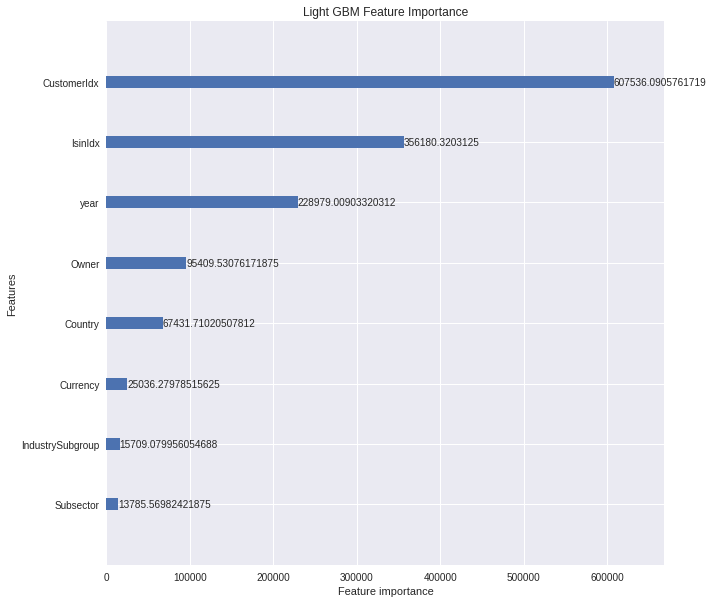

In [12]:
lgb.plot_importance(model,importance_type='gain',figsize=(10,10))
plt.title("Light GBM Feature Importance")

x = test[test.BuySell == 'Sell']['CustomerInterest']#.describe()
sns.distplot(x)

import catboost as cb
cat_features_index = [0,1]

'''
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}
cb = cb.CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)
cb_model.fit(train, y_train)
'''
#With Categorical features
clf = cb.CatBoostClassifier(eval_metric="AUC",one_hot_max_size=255,depth=3, iterations= 100, l2_leaf_reg= 9, learning_rate= 0.01)
clf.fit(trade.loc[train_index,predictors],trade.loc[train_index,target], cat_features= cat_features_index,
       eval_set=(trade.loc[valid_index,predictors],trade.loc[valid_index,target]),plot=True)

In [13]:
#Create valid
filtered = trade[(trade.year == 2018) & (trade.weekofyear >= 13) & (trade.CustomerInterest == True)].reset_index(drop=True)
filtered = filtered.drop_duplicates()
#filtered = filtered[['CustomerIdx','IsinIdx','BuySell','year','weekofyear']]
filtered_sell = filtered[['CustomerIdx','IsinIdx']].drop_duplicates()
filtered_buy = filtered_sell.copy()
filtered_sell['BuySell'] = 1
filtered_buy['BuySell'] = 0
filtered_valid_1 = pd.concat([filtered_sell,filtered_buy],axis=0)
filtered_valid_1['year'] = 2018.
filtered_valid_1['weekofyear'] = 13
filtered_valid_2 = filtered_valid_1.copy()
filtered_valid_2['weekofyear'] = 14
filtered_valid_3 = filtered_valid_1.copy()
filtered_valid_3['weekofyear'] = 15
filtered_valid_4 = filtered_valid_1.copy()
filtered_valid_4['weekofyear'] = 16
filtered_valid = pd.concat([filtered_valid_1,filtered_valid_2,filtered_valid_3,filtered_valid_4],axis=0)
del filtered_valid_1,filtered_valid_2,filtered_valid_3,filtered_valid_4,filtered_buy,filtered_sell
gc.collect()
filtered_valid = filtered_valid.merge(filtered,on=['CustomerIdx','IsinIdx','BuySell','year','weekofyear'],how='left')
filtered_valid['CustomerInterest'][filtered_valid.CustomerInterest.isnull()] = 0
filtered_valid.head()

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,CustomerIdx,IsinIdx,BuySell,year,weekofyear,month,CustomerInterest,Sector,Subsector,CustomerRegion,...,BondRegion,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,2,5215,1,2018.0,13,3.0,1.0,0.0,23.0,0.0,...,0.0,0.0,0.0,17.0,7.0,8.0,294.0,7.0,3.245605e+09,0.0
1,2,16812,1,2018.0,13,3.0,1.0,0.0,23.0,0.0,...,0.0,12.0,14.0,22.0,10.0,4.0,7.0,5.0,5.000000e+08,0.0
2,2,17091,1,2018.0,13,3.0,1.0,0.0,23.0,0.0,...,0.0,12.0,11.0,18.0,12.0,7.0,296.0,5.0,1.000000e+09,0.0
3,2,17275,1,2018.0,13,3.0,1.0,0.0,23.0,0.0,...,0.0,12.0,11.0,18.0,7.0,7.0,48.0,3.0,7.500000e+08,4.0
4,14,15545,1,2018.0,13,3.0,1.0,0.0,23.0,2.0,...,0.0,12.0,11.0,18.0,15.0,1.0,187.0,7.0,2.250000e+09,0.0


In [14]:
filtered_valid['predCustomerInterest'] = model.predict(filtered_valid.loc[:,predictors].values)
filtered_valid['predCustomerInterest'][filtered_valid.BuySell == 0] = 1 - filtered_valid['predCustomerInterest'][filtered_valid.BuySell == 0]

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
from sklearn.metrics import roc_auc_score
y_true = filtered_valid.CustomerInterest.astype(int).values
y_scores = filtered_valid.predCustomerInterest.values
roc_auc_score(y_true, y_scores)

0.5727372651259265

In [16]:
test = pd.read_csv('Challenge_20180423.csv',parse_dates=['DateKey'])
test = test.rename({'DateKey':'TradeDateKey'},axis=1)
test['BuySell'] = test['BuySell'].astype('category')
test['TradeDateKey'] = '20180423'
test['TradeDateKey'] = pd.to_datetime(test.TradeDateKey)
test['year'] = test.TradeDateKey.dt.year
test['month'] = test.TradeDateKey.dt.month
test['weekofyear'] = test.TradeDateKey.dt.weekofyear
encoder = LabelEncoder()
encoder.fit(test['BuySell'].astype(str))
test['BuySell'] = encoder.transform(test['BuySell'].astype(str))
encoder.transform(['Buy','Sell'])
#test['CustomerInterest'] = model.predict(test.loc[:,predictors].values)
#test['CustomerInterest'][test.BuySell == 'Buy'] = 1 - test['CustomerInterest'][test.BuySell == 'Buy']
#test[['PredictionIdx','CustomerInterest']].to_csv('submission_sambeet_buysell.csv', index=False)

array([0, 1])

In [18]:
test_13 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_13['weekofyear'] = 13
test_14 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_14['weekofyear'] = 14
test_15 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_15['weekofyear'] = 15
test_16 = test.drop(['TradeDateKey','month','CustomerInterest'],axis=1)
test_16['weekofyear'] = 16
test_local = pd.concat([test_13,test_14,test_15,test_16],axis=0)
del test_13,test_14,test_15,test_16
gc.collect()
trade2 = pd.read_csv('Trade.csv',parse_dates=['TradeDateKey'])
trade2['BuySell'] = trade2['BuySell'].astype('category')
trade2['TradeStatus'] = trade2['TradeStatus'].astype('category')
trade2['CustomerInterest'] = trade2['CustomerInterest'].astype('bool')
trade2['year'] = trade2.TradeDateKey.dt.year
trade2['month'] = trade2.TradeDateKey.dt.month
trade2['weekofyear'] = trade2.TradeDateKey.dt.weekofyear
customer = pd.read_csv('Customer.csv')
categorical_columns = ['Sector','Subsector','Region','Country']
for col in categorical_columns:
    customer[col] = customer[col].astype('category')
bond = pd.read_csv('Isin.csv',parse_dates=['ActualMaturityDateKey', 'IssueDateKey'])
categorical_columns = ['Seniority','Currency','ActivityGroup','Region','Activity',
       'RiskCaptain','Owner','CompositeRating','IndustrySector','IndustrySubgroup','MarketIssue','CouponType']
for col in categorical_columns:
    bond[col] = bond[col].astype('category')
customer = customer.rename({'Region':'CustomerRegion'},axis=1)

bond = bond.rename({'Region':'BondRegion'},axis=1)
trade2 = trade2.merge(customer,on=['CustomerIdx'],how='left')
trade2 = trade2.merge(bond,on=['IsinIdx'],how='left')
test = test.merge(customer,on=['CustomerIdx'],how='left')
test = test.merge(bond,on=['IsinIdx'],how='left')
test_local = test_local.merge(customer,on=['CustomerIdx'],how='left')
test_local = test_local.merge(bond,on=['IsinIdx'],how='left')

categorical_to_be_transformed = ['Sector','Subsector','CustomerRegion', 'Country','Seniority','Currency',
                                 'ActivityGroup', 'BondRegion', 'Activity', 'RiskCaptain', 'Owner', 
                                 'CompositeRating', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue','CouponType']
for feature in categorical_to_be_transformed:
    print 'Transforming {}...'.format(feature)
    encoder = LabelEncoder()
    encoder.fit(trade2[feature].append(test[feature]).astype(str))    
    test_local[feature] = encoder.transform(test_local[feature].astype(str))

test_local = test_local.merge(filtered[['CustomerIdx','IsinIdx','BuySell','year','weekofyear','CustomerInterest']],on=['CustomerIdx','IsinIdx','BuySell','year','weekofyear'],how='left')
test_local['CustomerInterest'][test_local.CustomerInterest.isnull()] = 0
test_local.head()

Transforming Sector...
Transforming Subsector...
Transforming CustomerRegion...
Transforming Country...
Transforming Seniority...
Transforming Currency...
Transforming ActivityGroup...
Transforming BondRegion...
Transforming Activity...
Transforming RiskCaptain...
Transforming Owner...
Transforming CompositeRating...
Transforming IndustrySector...
Transforming IndustrySubgroup...
Transforming MarketIssue...
Transforming CouponType...


/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PredictionIdx,CustomerIdx,IsinIdx,BuySell,year,weekofyear,Sector,Subsector,CustomerRegion,Country,...,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType,CustomerInterest
0,a1e0d80784,1856,13323,0,2018,13,0,24,0,95,...,3,4,96,9,4,225,7,4.500000e+08,0,0.0
1,c2cc6cc2a8,1856,9230,0,2018,13,0,24,0,95,...,3,4,87,7,7,194,10,4.000000e+08,0,0.0
2,a8e94f6344,1780,9157,0,2018,13,0,1,0,95,...,7,22,83,1,9,81,2,3.000000e+08,1,0.0
3,758bae1e35,2129,9131,0,2018,13,1,25,0,95,...,7,22,83,1,9,81,7,4.000000e+09,0,0.0
4,02ab378ee8,1758,7151,0,2018,13,0,1,0,95,...,7,24,79,14,12,92,10,3.000000e+08,0,0.0


In [19]:
test_local['predCustomerInterest'] = model.predict(test_local.loc[:,predictors].values)
test_local['predCustomerInterest'][test_local.BuySell == 0] = 1 - test_local['predCustomerInterest'][test_local.BuySell == 0]
y_true = test_local.CustomerInterest.astype(int).values
y_scores = test_local.predCustomerInterest.values
roc_auc_score(y_true, y_scores)

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.544224006734983

In [63]:
test_submit.head()

,PredictionIdx,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,year,month,weekofyear,Sector,...,BondRegion,Activity,RiskCaptain,Owner,CompositeRating,IndustrySector,IndustrySubgroup,MarketIssue,IssuedAmount,CouponType
0,a1e0d80784,2018-04-23,1856,13323,0,NaN,2018,4,17,0,...,0,3,4,96,9,4,224,7,4.500000e+08,0
1,c2cc6cc2a8,2018-04-23,1856,9230,0,NaN,2018,4,17,0,...,0,3,4,87,7,7,193,10,4.000000e+08,0
2,a8e94f6344,2018-04-23,1780,9157,0,NaN,2018,4,17,0,...,0,7,22,83,1,9,81,2,3.000000e+08,1
3,758bae1e35,2018-04-23,2129,9131,0,NaN,2018,4,17,1,...,0,7,22,83,1,9,81,7,4.000000e+09,0
4,02ab378ee8,2018-04-23,1758,7151,0,NaN,2018,4,17,0,...,0,7,24,79,14,12,91,10,3.000000e+08,0


In [64]:
test_submit['CustomerInterest'] = model.predict(test_submit.loc[:,predictors].values)
test_submit['CustomerInterest'][test_submit.BuySell == 0] = 1 - test_submit['CustomerInterest'][test_submit.BuySell == 0]
test_submit[['PredictionIdx','CustomerInterest']].to_csv('submission_sambeet_addingcustbondfeats.csv', index=False)

/home/sambeet/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [66]:
test_submit.CustomerInterest.describe()

count    484758.000000
mean          0.500000
std           0.157741
min           0.000164
25%           0.404283
50%           0.500000
75%           0.595717
max           0.999836
Name: CustomerInterest, dtype: float64